In [108]:
#all the imports used in the program

import pandas as pd 
import pyodbc
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import categorical_accuracy
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Embedding, Flatten, Dense, Bidirectional, LSTM
from keras.layers import GlobalMaxPool1D, Conv1D, Dropout, GRU, Flatten, MaxPooling1D
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import sklearn.metrics as skm

In [78]:
#Grab data from a database

def getData(Server, UID, PWD, Database, query):    
    
    #create a SQL connection based on the given server and database
    sql_conn = pyodbc.connect('DRIVER={SQL Server};'
                              'SERVER='+Server+';' 
                              'UID='+UID+';'
                              'PWD='+PWD+';'
                              'DATABASE='+Database+';' )
    
    #return the data from the given Query and SQL connection,
    return pd.read_sql(query, sql_conn)

In [79]:
#establish my server and corresponding database to pull data from
server ='GSDEMO2HOST'
database = 'MClinical'
UID = 'gsanalytics'
PWD = 'G3st@lt'


#Stores the result in a pandas DataFrame object called data
query ="SELECT ISNULL(ProcedureStep.subSpecialtyCd,'UNKNOWN') AS subSpecialtyCd, FillerOrder.fillerOrderStatusCd, PL.locationName, BUCKETS.BUCKETNUM FROM BUCKETS LEFT JOIN ProcedureStep ON BUCKETS.PSKEY = ProcedureSteP.procedureStepKey LEFT JOIN RequestedProcedure ON ProcedureStep.requestedProcedureKey = RequestedProcedure.requestedProcedureKey LEFT JOIN FillerOrder ON RequestedProcedure.fillerOrderKey = FillerOrder.fillerOrderKey LEFT JOIN LOCATION AS PL ON FillerOrder.scheduledLocationKey = PL.locationKey"
original = getData(server, UID, PWD, database,query)
data = original.copy()


In [80]:
#concatinate the selected params
def concatParam(df):
    return  df['subSpecialtyCd'] + ' ' + df['fillerOrderStatusCd'] + ' ' + df['locationName']

In [81]:
def clean(df):
    #create a new column where its all the params concatinated by spaces
    df['concat'] = concatParam(df)
    
    #change the case of all the words to lower case so there is no case sensitivity.
    df['concat'] = df['concat'].str.lower()
    return df['concat']

In [82]:
data['concat'] = clean(data)
data.concat.apply(lambda x: len(x.split(" "))).mean()

5.0

In [83]:
def convert_text(df, maxlen, max_words):
    #split df into two series
    #texts being the concat
    #labels being the cooresponding bucket
    texts = df.concat
    labels = df.BUCKETNUM
    
    #convert the series into numpy arrays
    texts = texts.values
    temp_labels = labels.values
    
    #create a empty array for our labels that we will convert to integers
    labels = []
    
    #grab all the unique buckets (5) 
    #this will be our dictonary for mapping between integers and buckets
    label_dict = [1,2,3,4,5]
    label_dict = np.asarray(label_dict)

    
    for label_type in temp_labels:
        labels.append(np.searchsorted(label_dict, label_type))
    
    labels = np.asarray(labels)
    
    #create a tokenizer based on the max_words
    #fit the tokenizer to our specific texts
    #change our texts to a vetorized integer
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    
    #pad sequences ensures that all our vectors are of the same length
    x = pad_sequences(sequences, maxlen=maxlen)
    
    

    print('Shape of data tensor:', x.shape)
    print('Shape of label tensor:', labels.shape)
    
    #return x, labels, and the last 7000 of x and labels for testing
    return x[:8000], labels[:8000], x[-2000:], labels[-2000:]

In [84]:
#define maxlen as the maximum words to take from each sectionValue
#define max_words as the total number of unique words to tokenize

maxlen = 8
max_words = 20

#create data that can be ran through our model
x_train, y_train, x_test, y_test = convert_text(data, maxlen, max_words)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

Found 20 unique tokens.
Shape of data tensor: (10000, 8)
Shape of label tensor: (10000,)
(8000, 8)
(8000,)
(2000, 8)
(2000,)


In [85]:
#create a machine learning model with the following
def create_model(max_words,maxlen):
    #keras default model
    model = Sequential()
    
    #add an embedding layer with the input dim and input length to what we have already
    #configured for our vectorized forms of our text
    model.add(Embedding(input_dim = max_words, input_length=maxlen, output_dim = 50))
    
    #model.add(Embedding(max_words,50, input_length=maxlen, embeddings_initializer="uniform"))
    
    #add a bidirectional LSTM layer with 32 units
    model.add(Bidirectional(LSTM(units =32)))
    
    #model.add(Conv1D(maxlen, 1, padding='valid', activation='relu', strides=1))
    #model.add(GlobalMaxPool1D())
    
    # create a dense output layer with the units = len(labels_dict)
    model.add(Dense(5, activation='softmax'))
    
    #print the summary
    model.summary()
    
    return model

In [97]:
#create the model
model = create_model(max_words, maxlen)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 8, 50)             1000      
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                21248     
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 325       
Total params: 22,573
Trainable params: 22,573
Non-trainable params: 0
_________________________________________________________________


In [98]:
#train the model
def train_model(model, x_train, y_train, epochs, batchsize, max_words, max_len):
    #compile the model
    #optimizer -> rmsprop (standard)
    #loss -> sparse categorical crossentropy (because we have a large multiclassifcation probelm)
    #meteric -> accuracy
    model.compile(optimizer='rmsprop',
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc']) 
    #save the history from the model
    #set the paramiters
    #fit the model 
    history = model.fit(x_train, 
                        y_train,
                        epochs=epochs,
                        batch_size=batchsize,
                        validation_split=0.2)
    return history

In [99]:
#train the model
history = train_model(model, x_train, y_train, 4, 120, max_words, maxlen)

Train on 6400 samples, validate on 1600 samples
Epoch 1/4
6400/6400 [==============================] - 4s 603us/step - loss: 1.2344 - acc: 0.5780 - val_loss: 0.5754 - val_acc: 0.9025
Epoch 2/4
6400/6400 [==============================] - 1s 106us/step - loss: 0.2881 - acc: 0.9361 - val_loss: 0.1226 - val_acc: 0.9769
Epoch 3/4
6400/6400 [==============================] - 1s 107us/step - loss: 0.0860 - acc: 0.9798 - val_loss: 0.0458 - val_acc: 0.9800
Epoch 4/4
6400/6400 [==============================] - 1s 106us/step - loss: 0.0309 - acc: 0.9939 - val_loss: 0.0180 - val_acc: 0.9969


In [109]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [100]:
#generate the report for the training process
def training_report(history):
    #get the data from the model history file 
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    #set our epochs
    epochs = range(1, len(acc) + 1)

    #plot the accuracy 
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    
    #plot the loss
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

    #display the max values we attained
    print('Validation Accuracy: ', val_acc[np.argmax(val_acc)] * 100)
    print('Training Accuracy: ', acc[np.argmax(acc)] * 100)

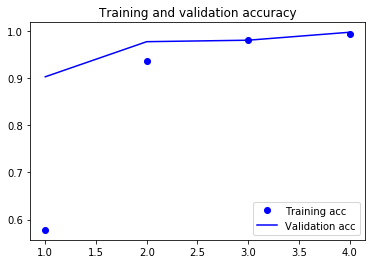

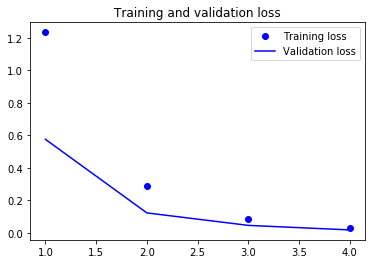

Validation Accuracy:  99.68750029802322
Training Accuracy:  99.39062546938658


In [101]:
training_report(history)

In [102]:
#test the model on our set aside testing data
def test_model(model, x_test):
    #gather the models prediction 
    
    #the model displays its prediction as a percent for every bucket at how confident the model is for 
    #each bucket. 
    
    #the highest percent in our case the the bucket the model has choosen
    preds = model.predict(x_test)
    
    y_pred = []
    
    #for ever row in the prediction list
    #grab the max value and append that index to the y_pred
    for row in preds:
        y_pred.append(np.argmax(row))
    
    #convert the list to a numpy array
    return np.asarray(y_pred)

In [103]:
#test the model against our test data and store the predictions in y_pred
y_pred = test_model(model, x_test)

In [104]:
#create the confusion matrix
def test_confusion_matrix(y_pred,y_test):
    print(confusion_matrix(y_test, y_pred))

In [105]:
#create the classification report
def test_classification_report(y_pred,y_test):
    print(skm.classification_report(y_test, y_pred))

In [106]:
test_confusion_matrix(y_pred,y_test)

[[941   0   0   0   0]
 [  0  80   0   0   0]
 [  0   0 728   0   0]
 [  0   0   0 108   0]
 [  0   0   0   0 143]]


In [107]:
#display the classification report on the predictions
test_classification_report(y_pred, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       941
           1       1.00      1.00      1.00        80
           2       1.00      1.00      1.00       728
           3       1.00      1.00      1.00       108
           4       1.00      1.00      1.00       143

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [21]:
#drop first n rows
def drop_first_n_rows(df, n):
    return df.iloc[n:]

In [22]:
#drop frist N rows in data
#WHERE N = #OF TRAIN DATA
data = drop_first_n_rows(data, 8000)

In [23]:
#convert the prediction number to bucket number
def convert_to_bucket(Y):
    #the prediction number is the index of the array 1,2,3,4,5 
    #just add 1 to index to correct the bucket number
    
    #for every index in y
    for row in range(0, len(Y)):
        #replace the value at the index with value + 1
        Y[row] = Y[row] + 1
        
    #return Y
    return Y

In [24]:
#convert pred
pred = convert_to_bucket(y_pred)

#convert test
test = convert_to_bucket(y_test)

In [25]:
#convert our n x 1 numpy array to a pandas df
pdpred = pd.DataFrame(pred)

In [26]:
#add the pred list to the original dataframe

data['pred'] = pdpred.values

In [27]:
#drop all the useless data

data = data.drop(['subSpecialtyCd', 'fillerOrderStatusCd', 'locationName'], axis =1)

In [28]:
#reindex the columns of the data
data = data.reindex(columns=['concat', 'BUCKETNUM', 'pred'])

In [29]:
#display the data
data.head(60)

,concat,BUCKETNUM,pred
8000,*gyp s incyte diagnostics spokane,1,1
8001,*gyp f incyte diagnostics spokane,1,1
8002,*gyp f incyte diagnostics spokane,1,1
8003,*gyp f incyte diagnostics spokane,1,1
8004,*ns f incyte diagnostics spokane,3,3
8005,*ns f incyte diagnostics spokane,3,3
8006,*gyp f incyte diagnostics spokane,1,1
8007,*gyp f incyte diagnostics spokane,1,1
8008,*gyp f incyte diagnostics spokane,1,1
8009,*ns f incyte diagnostics spokane,3,3
